# ONNX 检测演示

这个 notebook 支持：
- 指定文件夹图片检测
- 读取 JetRacer/普通摄像头进行检测


In [2]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

from onnx_detector import (
    OnnxYoloDetector,
    draw_detections,
    load_class_names,
)


In [3]:
# 路径配置
cwd = Path.cwd()
repo_root = cwd if (cwd / 'object_detection').exists() else cwd.parent

onnx_path = repo_root / 'runs/detect/runs/finetune/yolo26n_signs6/weights/best.onnx'  # 修改为你的 ONNX 模型路径
classes_path = repo_root / 'object_detection' / 'data' / 'signs_labeled' / 'classes.txt'

conf_thres = 0.25
iou_thres = 0.45
imgsz = None  # 例如 (640, 640) 或 640

detector = OnnxYoloDetector(
    onnx_path,
    class_names=load_class_names(classes_path),
    conf_thres=conf_thres,
    iou_thres=iou_thres,
    input_size=imgsz,
)


In [4]:
def show_bgr(image_bgr, title=None):
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    if title:
        plt.title(title)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


## 单张图片检测

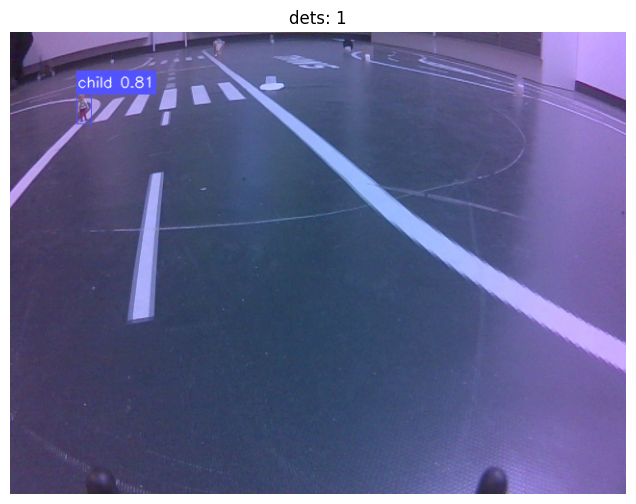

In [6]:
image_path = repo_root / 'object_detection' / 'data' / 'signs_labeled' / 'images' / 'collect1_frame_000488.jpg'
image = cv2.imread(str(image_path))
if image is None:
    raise FileNotFoundError(image_path)

detections = detector.predict(image)
vis = detector.visualize(image, detections)
show_bgr(vis, title=f'dets: {len(detections)}')


## 文件夹检测

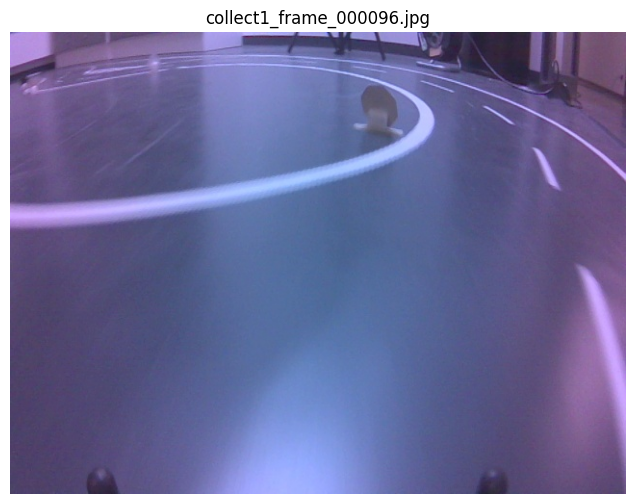

Saved to: /home/supercomputing/studys/smart_car/runs/onnx_detect_demo


In [ ]:
image_folder = repo_root / 'object_detection' / 'data' / 'signs_labeled' / 'images'
save_dir = repo_root / 'runs' / 'onnx_detect_demo'
save_dir.mkdir(parents=True, exist_ok=True)

count = 0
for img_path in sorted(image_folder.iterdir()):
    if img_path.suffix.lower() not in {'.jpg', '.jpeg', '.png', '.bmp'}:
        continue
    image = cv2.imread(str(img_path))
    if image is None:
        continue
    detections = detector.predict(image)
    vis = detector.visualize(image, detections)
    out_path = save_dir / img_path.name
    cv2.imwrite(str(out_path), vis)
    count += 1
    if count >= 100:
        show_bgr(vis, title=img_path.name)
        break

print(f'Saved to: {save_dir}')


## 摄像头检测 (JetRacer / USB)

In [ ]:
from IPython.display import display, clear_output

def iter_camera_frames(num_frames=50, width=640, height=480, fps=30):
    try:
        from jetcam.csi_camera import CSICamera
        camera = CSICamera(width=width, height=height, fps=fps)
        for _ in range(num_frames):
            frame = camera.read()
            if frame is None:
                continue
            yield frame
    except Exception:
        cap = cv2.VideoCapture(0)
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        for _ in range(num_frames):
            ok, frame = cap.read()
            if not ok:
                break
            yield frame
        cap.release()

for frame in iter_camera_frames(num_frames=20):
    detections = detector.predict(frame)
    vis = detector.visualize(frame, detections)
    clear_output(wait=True)
    display(vis[:, :, ::-1])  # BGR to RGB
